## **Dataset Description**

The dataset used in this study is derived from the [**Sloan Digital Sky Survey (SDSS) DR17**](https://www.sdss.org/dr17/), the final release of the SDSS-IV phase. SDSS is one of the largest astronomical surveys, providing optical and near-infrared observations of **stars, galaxies, and quasars**.  

This dataset contains **100,000 spectroscopic observations** collected by the **2.5m telescope at Apache Point Observatory**. Each record includes **17 numerical and categorical features** and one target label indicating the object type — *star, galaxy, or quasar*. The goal is to **classify celestial objects** based on their photometric and spectroscopic characteristics.  

**Reference:**  
[1] [Sloan Digital Sky Survey (SDSS) DR17 – Official Website](https://www.sdss.org/dr17/)\
[2] [The Seventeenth Data Release of the Sloan Digital Sky Surveys](https://arxiv.org/abs/2112.02026)

## Feature Description

Each row in the dataset represents one celestial object characterized by the following features:

| **Feature**     | **Description**                                                                                                                |
| --------------- | ------------------------------------------------------------------------------------------------------------------------------ |
| `obj_ID`        | Unique identifier assigned in the SDSS catalog. Links photometric and spectroscopic data.                                      |
| `alpha` *(RA)*  | Angular coordinate (in degrees) along the celestial equator.                                                                   |
| `delta` *(Dec)* | Angular coordinate (in degrees) north or south of the celestial equator.                                                       |
| `u, g, r, i, z` | Apparent magnitudes in five SDSS filters — ultraviolet *(u)*, green *(g)*, red *(r)*, near-infrared *(i)*, and infrared *(z)*. |
| `run_ID`        | Imaging run identifier. Useful for calibration.                                                                                |
| `rerun_ID`      | Specifies image reprocessing or recalibration details.                                                                         |
| `cam_col`       | Camera column number (1–6) used for imaging.                                                                                   |
| `field_ID`      | Identifies the sky field where the object was imaged.                                                                          |
| `spec_obj_ID`   | Unique spectroscopic identifier linking to the object’s spectrum. Crucial for determining **redshift** and **class**.          |
| `class`         | Target label specifying object type — *STAR*, *GALAXY*, or *QSO (quasar)* — determined via spectral template fitting.          |
| `redshift (z)`  | Dimensionless measure of wavelength shift (*Δλ/λ*). Distinguishes stars (≈0), galaxies (0.01–0.5), and quasars (>1).           |
| `plate`         | Identifier for the metal plate used in the SDSS spectrograph.                                                                  |
| `MJD`           | Modified Julian Date of observation.                                                                                           |
| `fiber_ID`      | Fiber number (1–640) corresponding to the position on the spectrographic plate.                                                |


## Feature Relevance for Classification

#### 1. Spectroscopic Features

> The **redshift** and spectral line patterns (accessible via **spec_obj_ID**) are the primary discriminators:
>
> * **Stars:** *z ≈ 0*
> * **Galaxies:** *0.01 < z < 0.5*
> * **Quasars:** *z > 1*
>
> Redshift reflects the wavelength displacement due to cosmic expansion or Doppler effects, making it the most decisive feature for distinguishing extragalactic objects.

#### 2. Photometric Features

> The **u, g, r, i, z** magnitudes and their derived color indices capture the continuum shape of the **spectral energy distribution (SED)** and allow efficient pre-classification even before spectroscopy.
>
> Color indices such as *(u−g)*, *(g−r)*, *(r−i)*, and *(i−z)* reveal distinct patterns:
>
> * **Stars:** Small *(u−g)* and *(g−r)* values
> * **Galaxies:** Redder colors from older stellar populations and dust extinction
> * **Quasars:** Very blue *(u−g)* values due to strong ultraviolet excess

#### 3. Positional Context

> Features like **alpha (RA)**, **delta (Dec)**, and **field_ID** provide weak spatial priors:
>
> * Low Galactic latitudes → mostly **stars**
> * High Galactic latitudes → more **galaxies** and **quasars**

#### 4. Calibration Metadata

> Features such as **run_ID**, **rerun_ID**, **plate**, and **fiber_ID** ensure data traceability and calibration consistency.  
> These do **not** influence physical classification directly.


# **Import the dataset**

### **Stellar Classification Dataset**

In [ ]:
import kagglehub
# loading the dataset
path = kagglehub.dataset_download("fedesoriano/stellar-classification-dataset-sdss17")

print("Path to dataset files:", path)

100%|██████████| 6.89M/6.89M [00:02<00:00, 3.09MB/s]

Extracting files...
Path to dataset files: C:\Users\hp\.cache\kagglehub\datasets\fedesoriano\stellar-classification-dataset-sdss17\versions\1


**IMPORTS**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns

# **Dataset visualisation and Preprocessing**

In [8]:
df = pd.read_csv(path + "/star_classification.csv")
df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


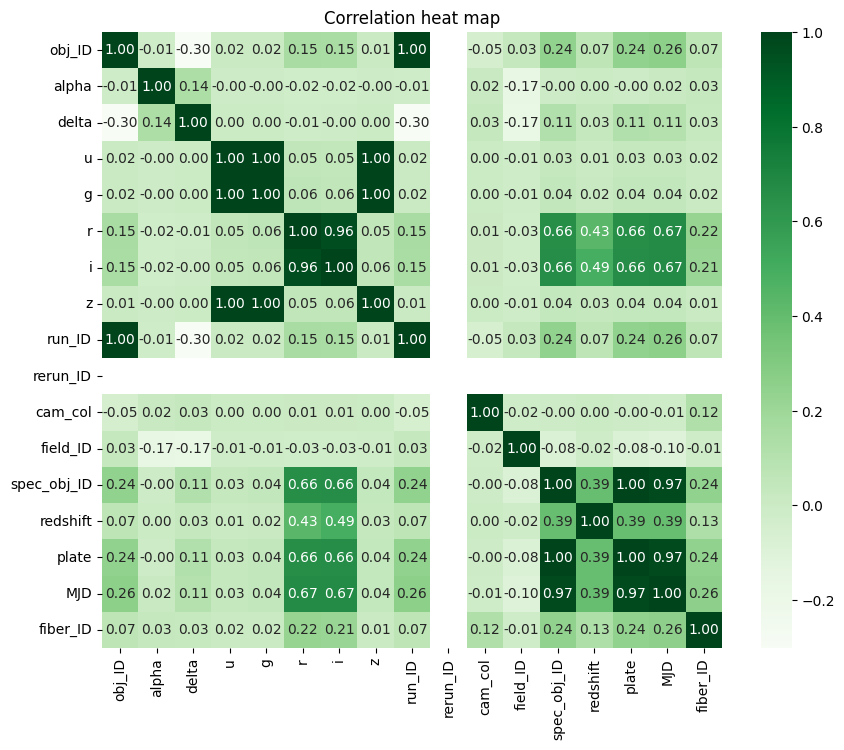

In [ ]:
# plotting the correlation heat map
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(numeric_only=True),annot=True,cmap='Greens',fmt=".2f")
plt.title("Correlation heat map")
plt.show()

**Feature Reduction (Feature Selection using specialized knowledge)**

| **Column**    | **Reason for Removal**                                                                                                  |
| ------------- | ----------------------------------------------------------------------------------------------------------------------- |
| `obj_ID`      | Purely an index or key; contains no physical or photometric information about the object.                               |
| `spec_obj_ID` | Identifies a measurement instance, not a measurable feature. Including it would introduce meaningless numeric variance. |
| `rerun_ID`    | Used for data provenance and quality tracking; does not reflect any astrophysical property.                             |
| `run_ID`      | Encodes when and where the observation occurred — not intrinsic to the object’s spectrum or class.                      |
| `cam_col`     | Relates to instrument geometry; has no correlation with the physical class of the observed object.                      |
| `field_ID`    | Represents sky segmentation; objects from the same field can belong to any class, so it adds noise.                     |
| `plate`       | Instrumental reference only; does not affect the spectrum’s physical interpretation.                                    |
| `MJD`         | Observation time; irrelevant to the intrinsic properties of stars, galaxies, or quasars in a static snapshot dataset.   |
| `fiber_ID`    | Hardware mapping reference; not related to object characteristics.                                                      |




In [ ]:
# droping features
df.drop(columns=['obj_ID', 'spec_obj_ID','rerun_ID','run_ID','cam_col','field_ID','plate','MJD','fiber_ID'], inplace=True)
df.head()

,alpha,delta,u,g,r,i,z,class,redshift
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,GALAXY,0.634794
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,GALAXY,0.779136
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,GALAXY,0.644195
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,GALAXY,0.932346
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,GALAXY,0.116123


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   alpha     100000 non-null  float64
 1   delta     100000 non-null  float64
 2   u         100000 non-null  float64
 3   g         100000 non-null  float64
 4   r         100000 non-null  float64
 5   i         100000 non-null  float64
 6   z         100000 non-null  float64
 7   class     100000 non-null  object 
 8   redshift  100000 non-null  float64
dtypes: float64(8), object(1)
memory usage: 6.9+ MB


These features capture intrinsic properties of stars, galaxies, and quasars and are directly used by the SDSS classification pipeline.
| **Feature**               | **Type**               | **Reason for Inclusion**                                                                                                                                                                                                  |
| ------------------------- | ---------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `alpha` (Right Ascension) | Positional             | Provides the object’s celestial coordinate. While weakly correlated with class, it can offer contextual priors (e.g., objects near the Galactic plane are more likely to be stars).                                       |
| `delta` (Declination)     | Positional             | Complements Right Ascension to specify sky position. Useful for spatial context, though not strongly discriminative by itself.                                                                                            |
| `u`, `g`, `r`, `i`, `z`   | Photometric Magnitudes | Measure an object’s brightness in five wavelength bands — from ultraviolet to infrared. These values represent the spectral energy distribution (SED) and are fundamental for identification. |
| `redshift`                | Spectroscopic          | Measures the fractional shift in observed wavelength. This is the most decisive feature: stars have $z \approx 0$, galaxies have moderate $z$, and quasars have large $z$.                                                |
| `u_g = u - g`             | Derived Color Index    | Represents the ultraviolet–green color. Sensitive to UV excess — quasars and hot stars show small $(u-g)$ values.                                                                                                         |
| `g_r = g - r`             | Derived Color Index    | Indicates the blue–red color difference. Useful to separate galaxies (redder) from stars (bluer).                                                                                                                         |
| `r_i = r - i`             | Derived Color Index    | Traces the continuum slope in the red–infrared region. Helps in distinguishing late-type stars and red galaxies.                                                                                                          |
| `i_z = i - z`             | Derived Color Index    | Captures near-infrared color, valuable for identifying very cool stars or highly redshifted galaxies/quasars.                                                                                                             |


In [ ]:
# Adding additional features based on suggestions in the paper
df['u_g'] = df['u'] - df['g']
df['g_r'] = df['g'] - df['r']
df['r_i'] = df['r'] - df['i']
df['i_z'] = df['i'] - df['z']
df.head()

,alpha,delta,u,g,r,i,z,class,redshift,u_g,g_r,r_i,i_z
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,GALAXY,0.634794,1.60352,1.88029,1.22928,0.37202
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,GALAXY,0.779136,1.94571,0.24744,1.41632,-0.44615
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,GALAXY,0.644195,2.59918,2.05413,1.26119,0.40030
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,GALAXY,0.932346,-1.63974,2.16494,1.10708,1.25444
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,GALAXY,0.116123,1.85690,1.08281,0.52036,0.43250


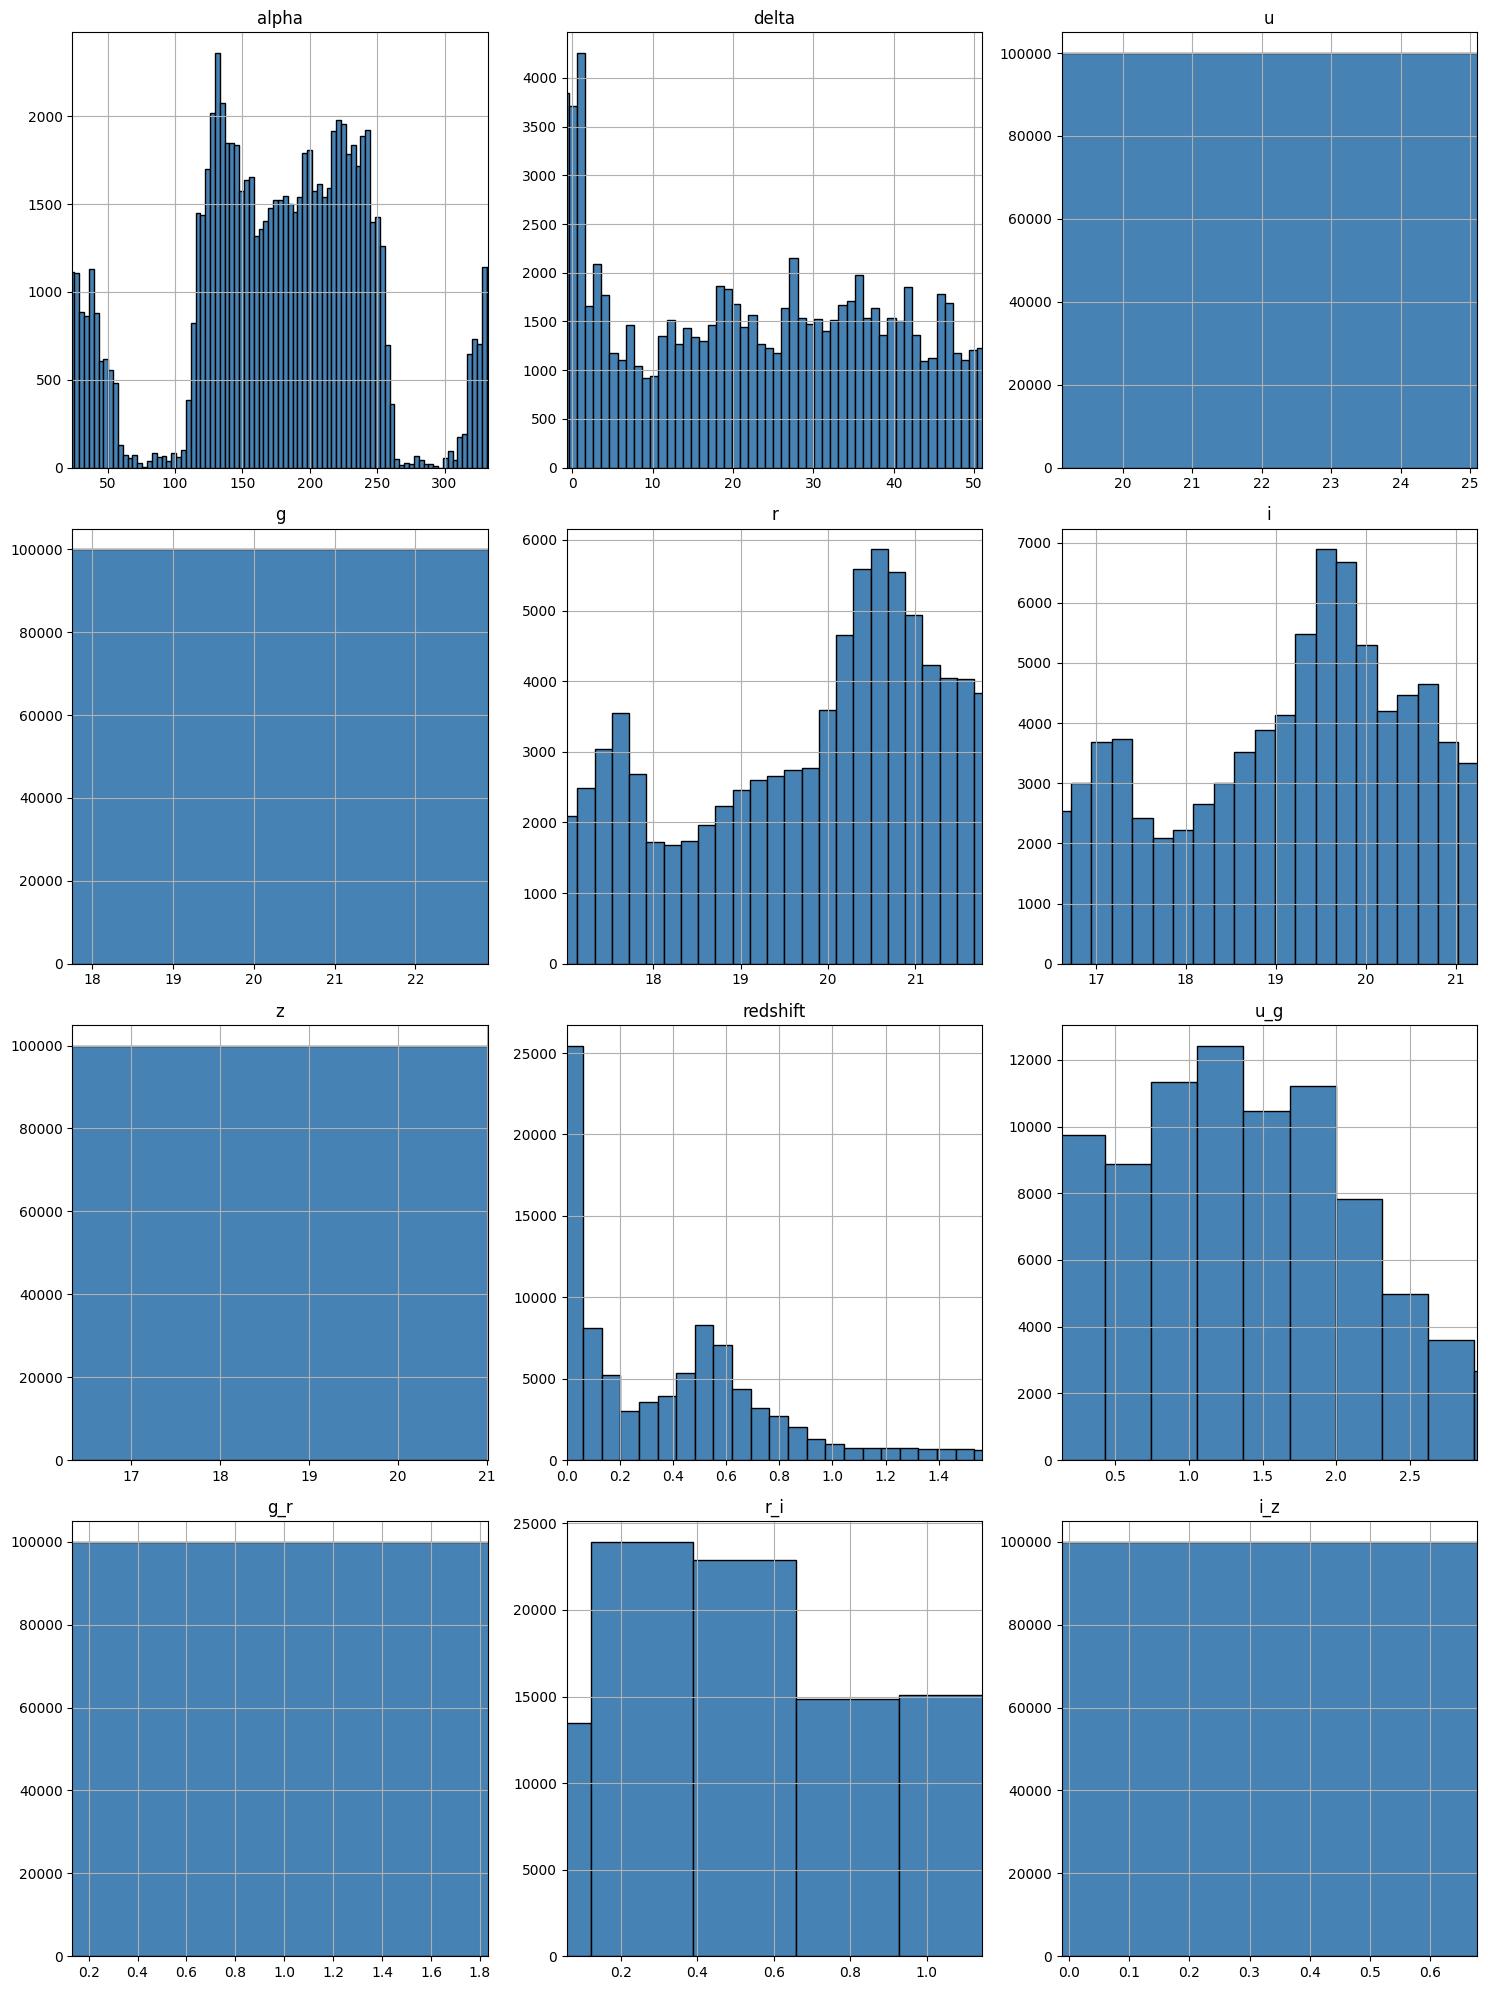

In [ ]:
# Feature distribution  (Histogram)
num_cols = df.select_dtypes(include=[np.number]).columns
n_cols = len(num_cols)


n_rows = int(np.ceil(n_cols / 3))  
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5 * n_rows))
axes = axes.flatten()  

for i, column in enumerate(num_cols):
    ax = axes[i]
    ax.hist(df[column], bins=100, color='steelblue', edgecolor='black')
    ax.set_xlim(df[column].quantile(0.1), df[column].quantile(.9))
    ax.set_title(column)
    ax.grid(True)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

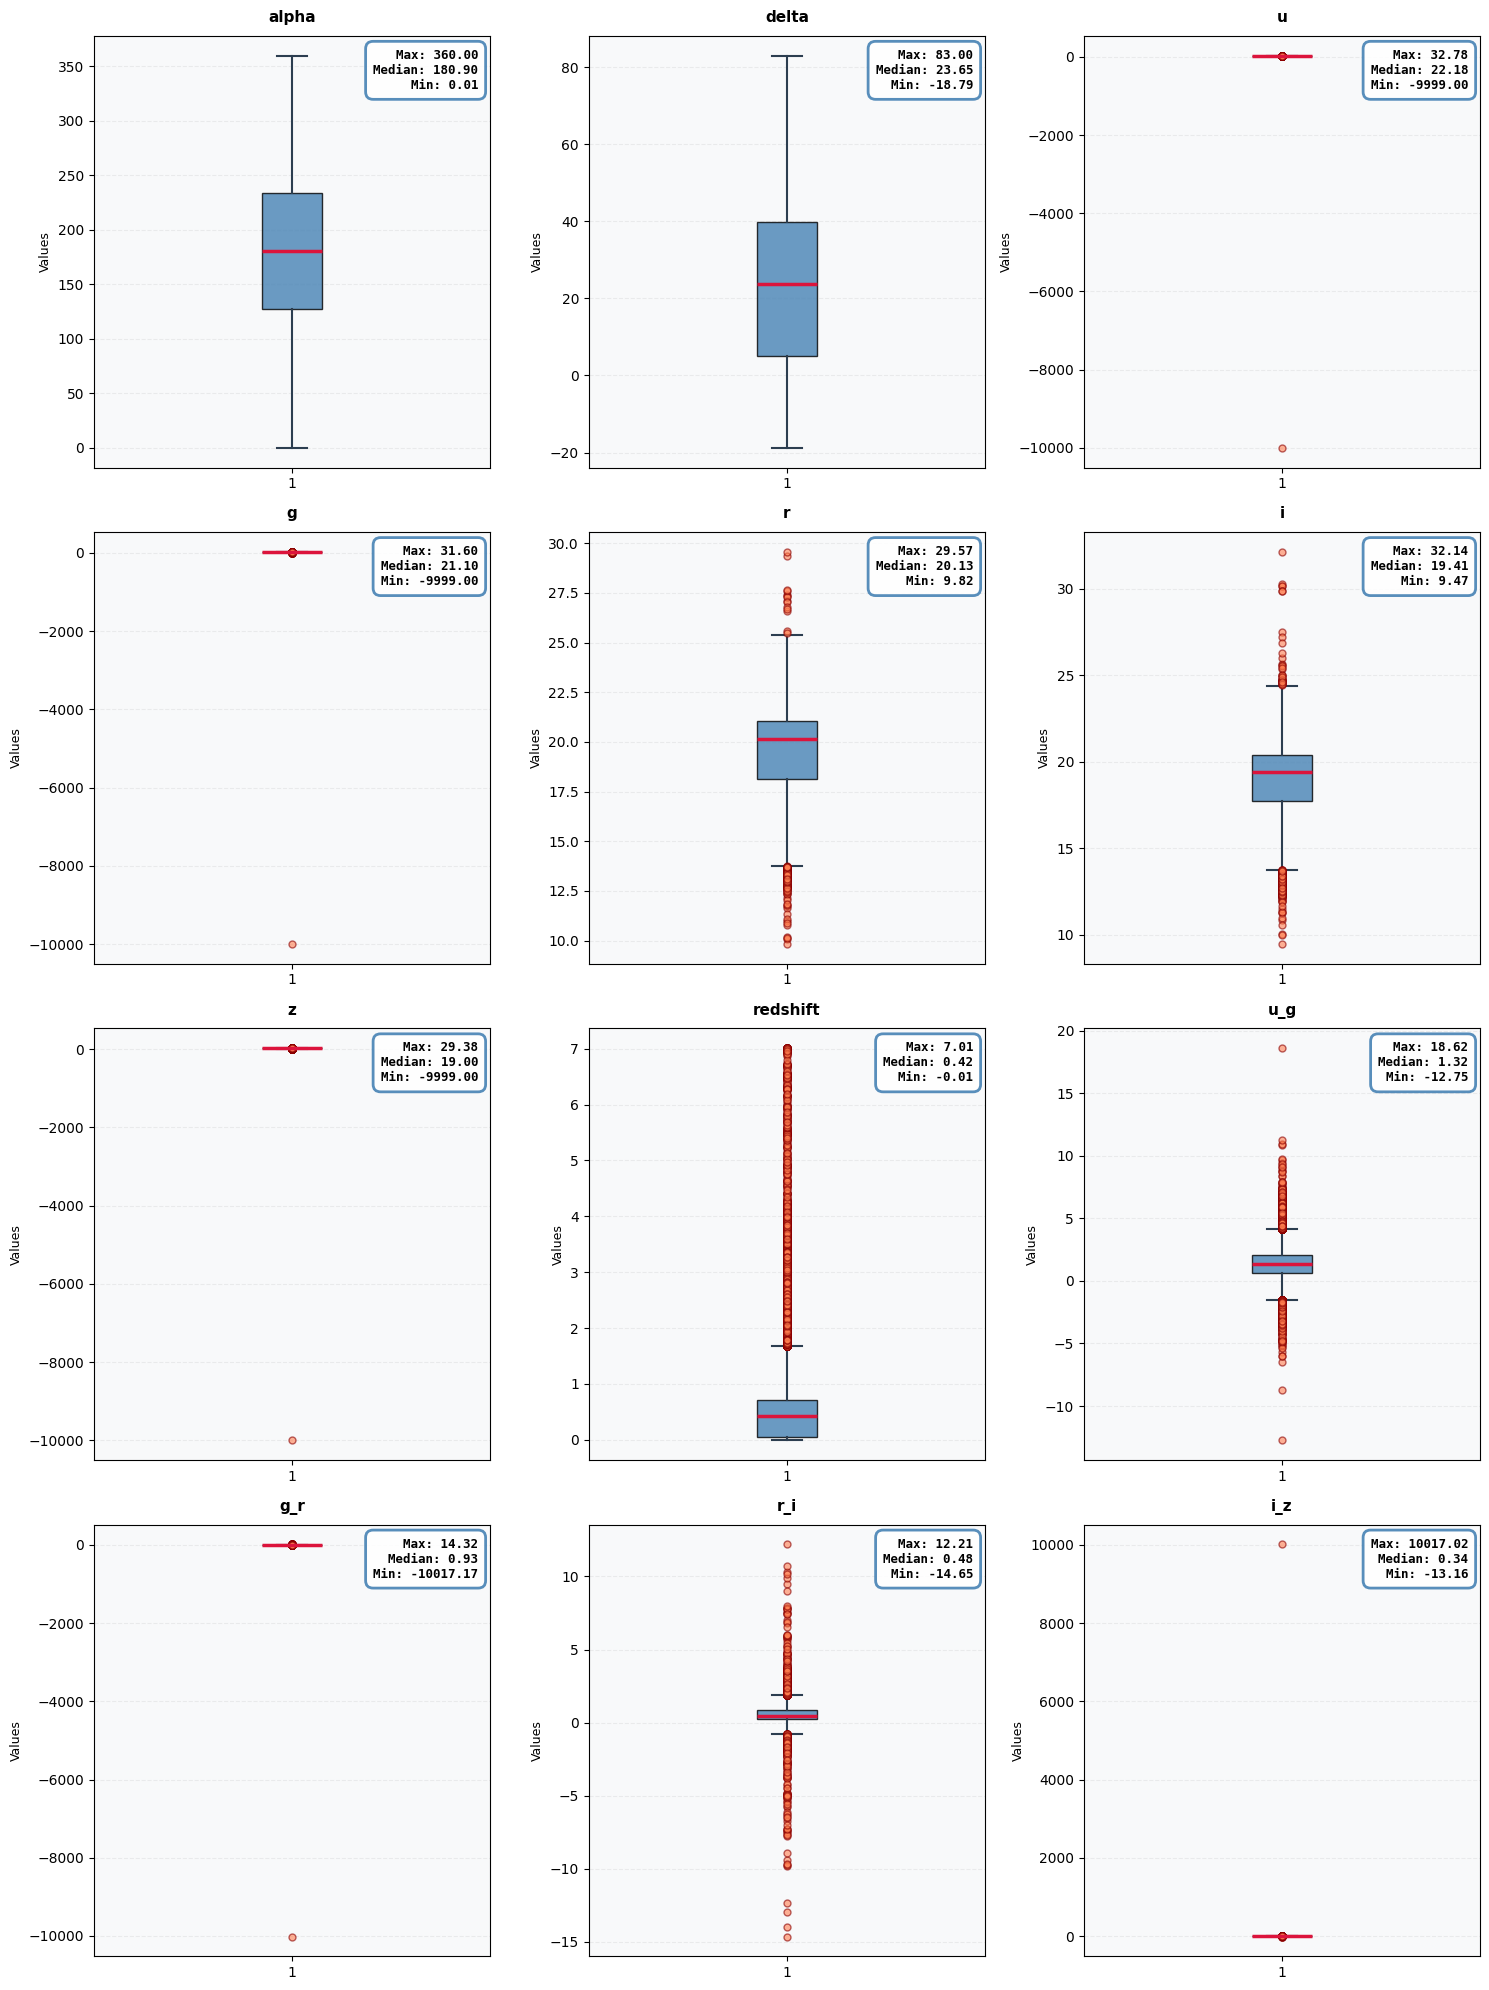

In [ ]:
# Feature distribution  (Box plot)
num_cols = df.select_dtypes(include=[np.number]).columns
n_cols = len(num_cols)

n_rows = int(np.ceil(n_cols / 3))  
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5 * n_rows))
axes = axes.flatten()  

for i, column in enumerate(num_cols):
    ax = axes[i]
    data = df[column].dropna()

    bp = ax.boxplot(data, vert=True, patch_artist=True,
                    boxprops=dict(facecolor='steelblue', alpha=0.8),
                    medianprops=dict(color='crimson', linewidth=2.5),
                    whiskerprops=dict(color='#2c3e50', linewidth=1.5),
                    capprops=dict(color='#2c3e50', linewidth=1.5),
                    flierprops=dict(marker='o', markerfacecolor='coral',
                                   markersize=5, alpha=0.6, markeredgecolor='darkred'))
    median = data.median()
    min_val = data.min()
    max_val = data.max()

    legend_text = f'Max: {max_val:.2f}\nMedian: {median:.2f}\nMin: {min_val:.2f}'

    ax.text(0.97, 0.97, legend_text, transform=ax.transAxes,
            fontsize=9, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round,pad=0.6', facecolor='white',
                     edgecolor='steelblue', linewidth=2, alpha=0.9),
            fontfamily='monospace', fontweight='bold')

    ax.set_title(column, fontsize=11, fontweight='bold', pad=10)
    ax.set_ylabel('Values', fontsize=9)
    ax.grid(True, alpha=0.2, axis='y', linestyle='--')
    ax.set_facecolor('#f8f9fa')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
# Seperating the data frame to feature table and label(target) vector
Y = df['class']
X = df.drop(columns=['class'])

print(len(X),len(Y))

100000 100000


C:\Users\hp\AppData\Local\Temp\ipykernel_3316\1180236328.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=Y, palette="viridis")


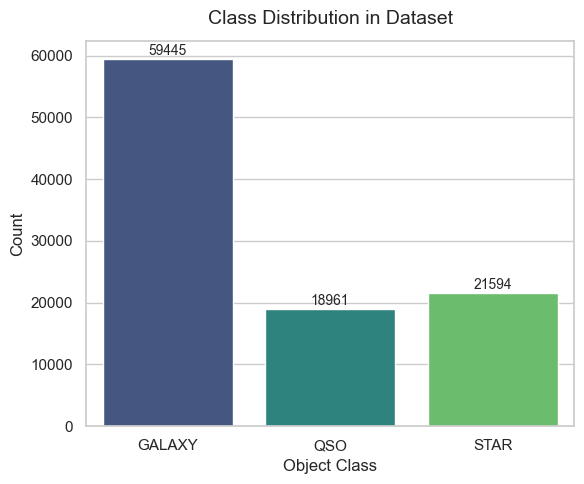

In [ ]:
# Checking Class imbalance
sns.set(style="whitegrid")

plt.figure(figsize=(6, 5))
sns.countplot(x=Y, palette="viridis")
plt.title("Class Distribution in Dataset", fontsize=14, pad=12)
plt.xlabel("Object Class", fontsize=12)
plt.ylabel("Count", fontsize=12)

for p in plt.gca().patches:
    plt.gca().text(
        p.get_x() + p.get_width() / 2,
        p.get_height() + 200, 
        int(p.get_height()),
        ha='center', va='bottom', fontsize=10
    )

plt.tight_layout()
plt.show()

# **Basic Models**

1.   Gaussian Naive-Bayes  
2.   Multiclass Logistic Regression
3.   Scaled Multiclass Logistic Regression
4.   K-NN Classifier





## **Gaussian Naive-Bayes**

In [22]:
from sklearn.naive_bayes import GaussianNB

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = GaussianNB()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

      GALAXY       0.61      0.98      0.75     11860
         QSO       0.52      0.12      0.19      3797
        STAR       0.00      0.00      0.00      4343

    accuracy                           0.60     20000
   macro avg       0.37      0.37      0.31     20000
weighted avg       0.46      0.60      0.48     20000



C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

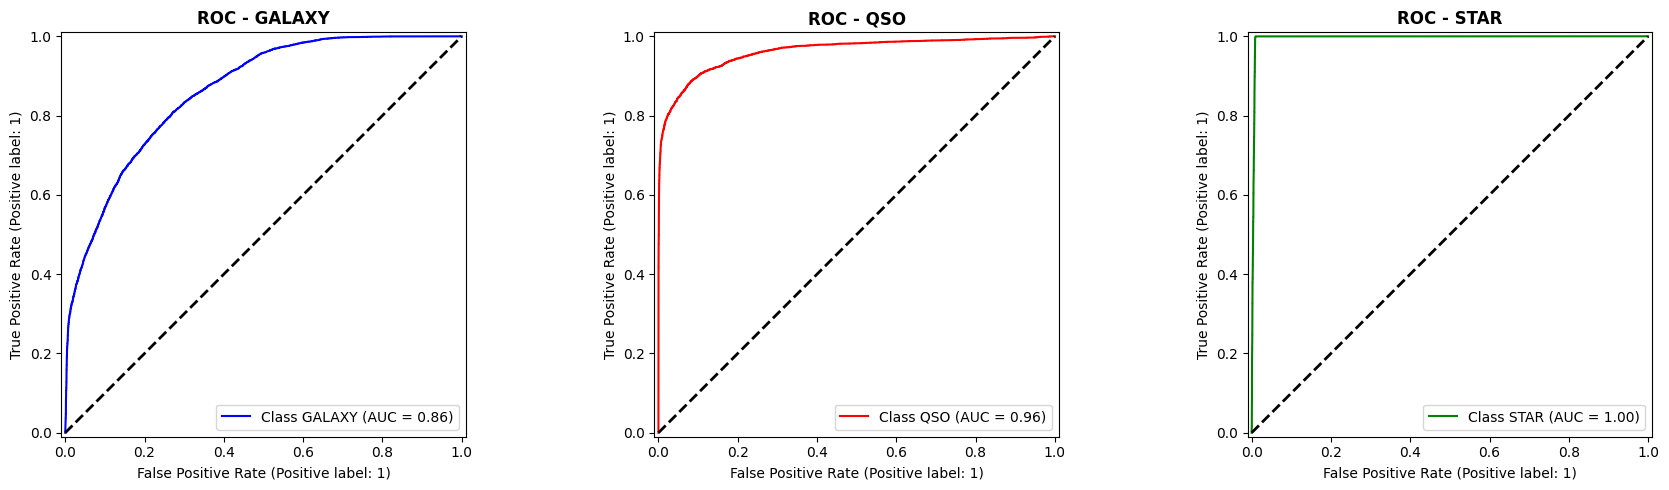

In [ ]:
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import label_binarize


classes = model.classes_  
y_test_bin = label_binarize(Y_test, classes=classes)
y_score = model.predict_proba(X_test)

fig, axes = plt.subplots(1, len(classes), figsize=(18, 5))
colors = ['blue', 'red', 'green']

for i, (ax, class_name, color) in enumerate(zip(axes, classes, colors)):
    RocCurveDisplay.from_predictions(
        y_test_bin[:, i],
        y_score[:, i],
        name=f"Class {class_name}",
        ax=ax,
        color=color
    )
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_title(f"ROC - {class_name}", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


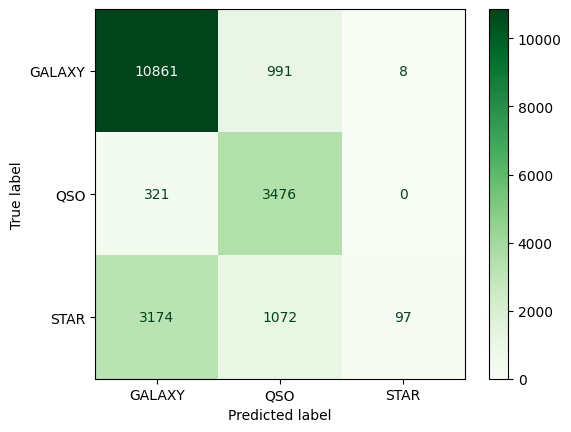

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_test, Y_pred, labels=['GALAXY','QSO','STAR'])
disp = ConfusionMatrixDisplay(cm, display_labels=['GALAXY','QSO','STAR'])
disp.plot(cmap='Greens', values_format='d')
plt.show()


### Inference 

**Galaxy**: Over-predicted (92% recall, 76% precision) - model's default choice

**Star**: Catastrophic failure (2% recall) - barely detecting stars despite 92% precision when it does

**QSO**: Moderate (74% F1) - acceptable but improvable

**Root Issue**: Class imbalance (11,860 galaxies vs 4,343 stars) + Gaussian Naive Bayes assumptions fail for correlated astronomical color indices


### **Multiclass Logistic Regression**

In [32]:
from sklearn.linear_model import LogisticRegression

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

model = LogisticRegression(max_iter=1000, class_weight='balanced',solver='lbfgs')
model.fit(X_train,Y_train)

Y_pred = model.predict(X_test)

print(classification_report(Y_test,Y_pred))

/home/simeon/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

      GALAXY       0.97      0.91      0.94     11860
         QSO       0.85      0.92      0.88      3797
        STAR       0.90      1.00      0.95      4343

    accuracy                           0.93     20000
   macro avg       0.91      0.94      0.92     20000
weighted avg       0.93      0.93      0.93     20000



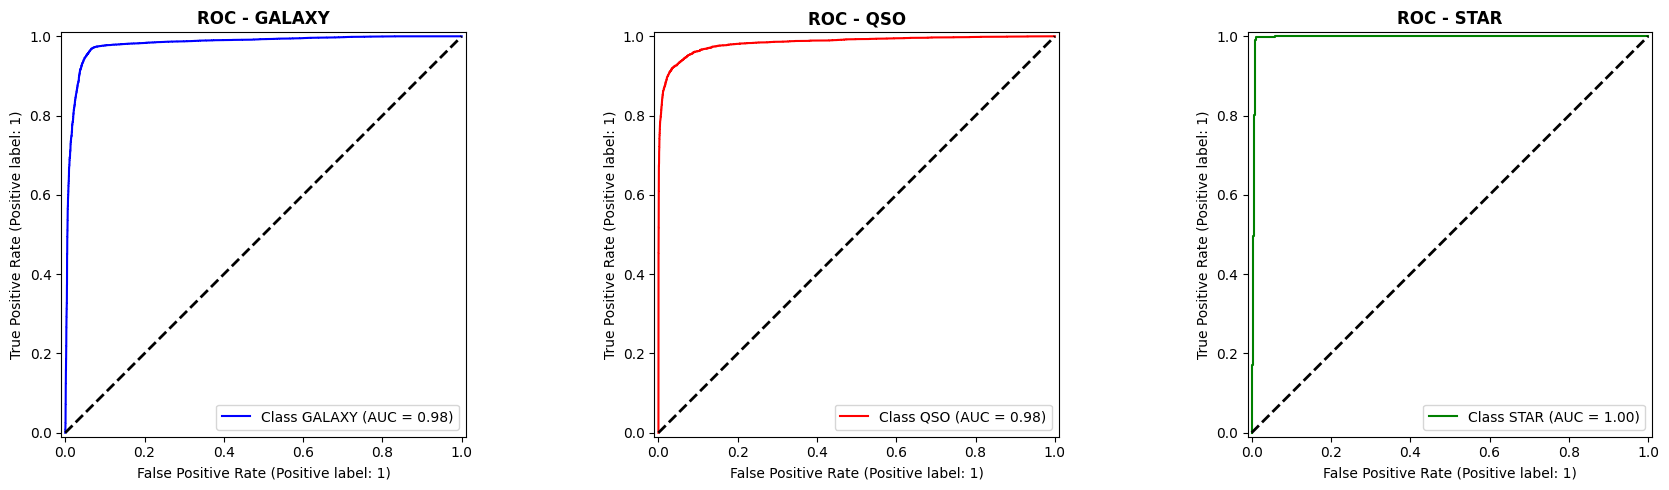

In [ ]:
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import label_binarize


classes = model.classes_ 
y_test_bin = label_binarize(Y_test, classes=classes)
y_score = model.predict_proba(X_test)

fig, axes = plt.subplots(1, len(classes), figsize=(18, 5))
colors = ['blue', 'red', 'green']

for i, (ax, class_name, color) in enumerate(zip(axes, classes, colors)):
    RocCurveDisplay.from_predictions(
        y_test_bin[:, i],
        y_score[:, i],
        name=f"Class {class_name}",
        ax=ax,
        color=color
    )
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_title(f"ROC - {class_name}", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


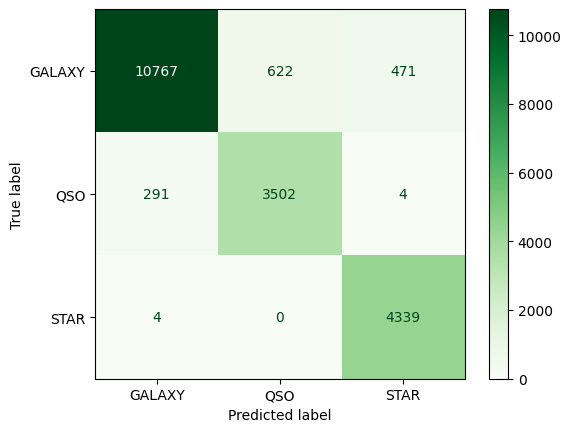

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_test, Y_pred, labels=['GALAXY','QSO','STAR'])
disp = ConfusionMatrixDisplay(cm, display_labels=['GALAXY','QSO','STAR'])
disp.plot(cmap='Greens', values_format='d')
plt.show()


### Inference 

* Why Standard Logistic Regression Fails ? \
Standard logistic regression is **binary** and cannot directly handle multiple classes (`STAR`, `GALAXY`, `QSO`).

* Multiclass Logistic Regression \
We use **multinomial (softmax) logistic regression** to predict probabilities for all three classes at once.

* Using `class_weight='balanced'` \
The dataset is **imbalanced** (GALAXY >> QSO, STAR).  
`class_weight='balanced'` ensures the model **pays equal attention to minority classes**, improving recall and F1-score.

### **Scaled Multiclass Logistic Regression**

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

In [25]:
sc = StandardScaler()
Xsc_train = sc.fit_transform(X_train)
Xsc_test = sc.transform(X_test)

In [26]:
model = LogisticRegression(max_iter=1000, class_weight='balanced',solver='lbfgs')
model.fit(Xsc_train,Y_train)

Y_pred = model.predict(Xsc_test)

print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

      GALAXY       0.97      0.92      0.95     11860
         QSO       0.87      0.92      0.90      3797
        STAR       0.91      1.00      0.95      4343

    accuracy                           0.94     20000
   macro avg       0.92      0.95      0.93     20000
weighted avg       0.94      0.94      0.94     20000



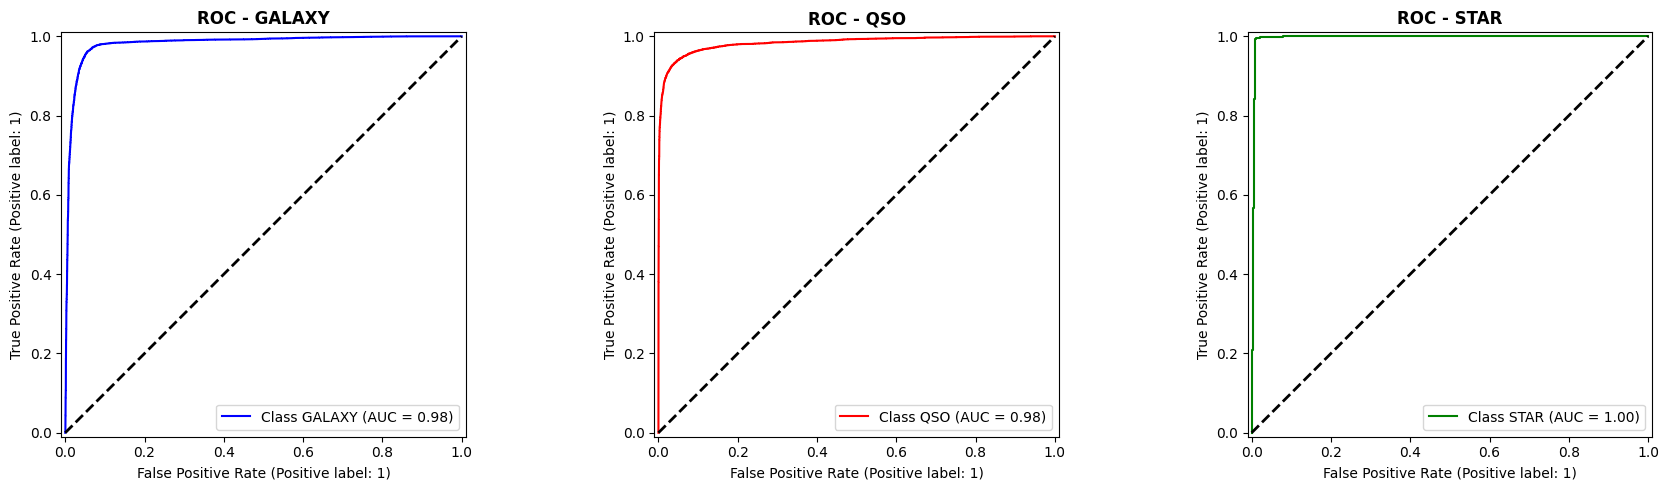

In [ ]:
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import label_binarize


classes = model.classes_  
y_test_bin = label_binarize(Y_test, classes=classes)
y_score = model.predict_proba(Xsc_test)

fig, axes = plt.subplots(1, len(classes), figsize=(18, 5))
colors = ['blue', 'red', 'green']

for i, (ax, class_name, color) in enumerate(zip(axes, classes, colors)):
    RocCurveDisplay.from_predictions(
        y_test_bin[:, i],
        y_score[:, i],
        name=f"Class {class_name}",
        ax=ax,
        color=color
    )
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_title(f"ROC - {class_name}", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


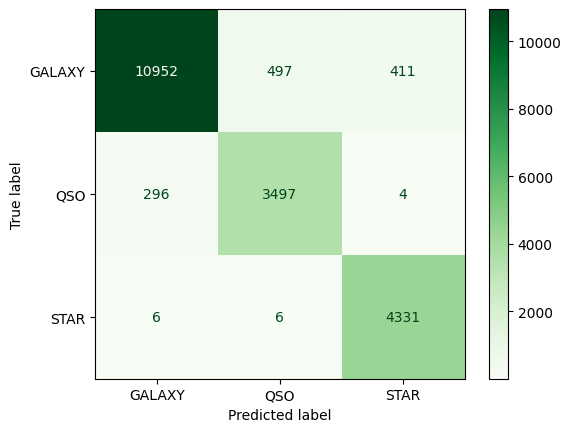

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_test, Y_pred, labels=['GALAXY','QSO','STAR'])
disp = ConfusionMatrixDisplay(cm, display_labels=['GALAXY','QSO','STAR'])
disp.plot(cmap='Greens', values_format='d')
plt.show()


### Inference
* **Feature Scaling** \
The SDSS dataset contains features with very different ranges —  for example, RA/Dec (sky coordinates) are in **hundreds of degrees**,  while magnitudes (`u, g, r, i, z`) are typically between **15–25**.  

* We applied **StandardScaler** to scale all numerical features to zero mean and unit variance. \ 
This ensures all features contribute equally, improves solver convergence, and led to **94% accuracy**

### **KNN - Classifier**

In [33]:
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = KNeighborsClassifier(n_neighbors=5) # euclidean p=2
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

      GALAXY       0.85      0.94      0.89     11860
         QSO       0.84      0.81      0.83      3797
        STAR       0.79      0.57      0.66      4343

    accuracy                           0.84     20000
   macro avg       0.83      0.78      0.79     20000
weighted avg       0.83      0.84      0.83     20000



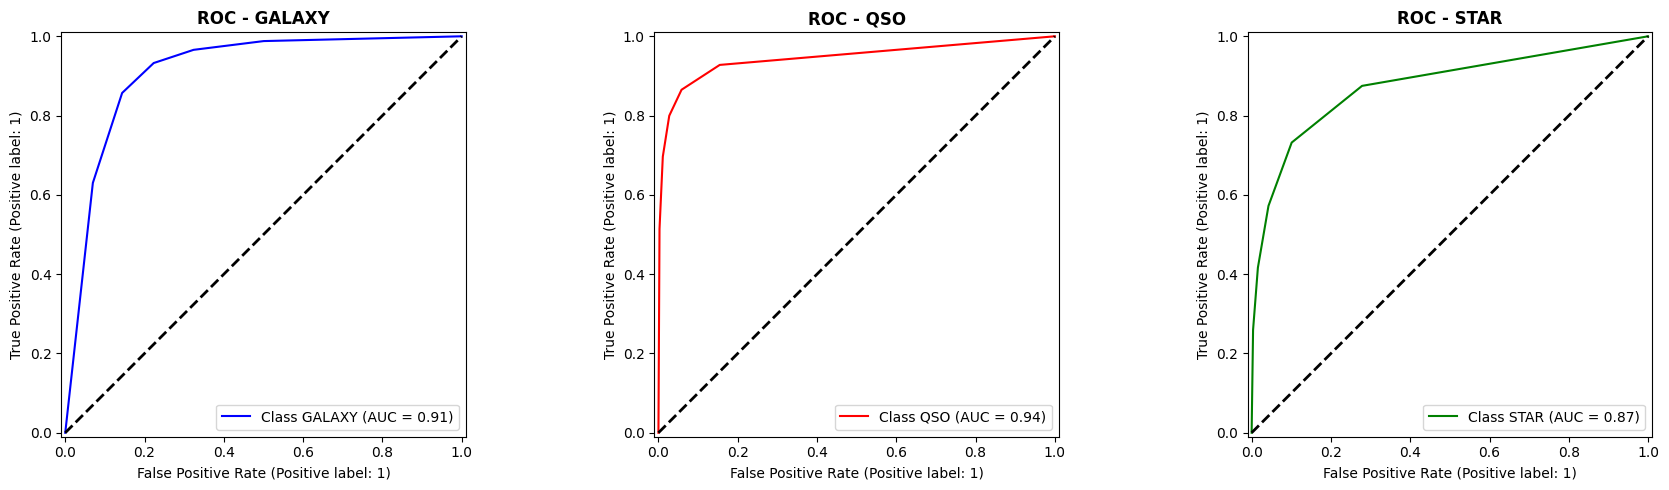

In [ ]:
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import label_binarize


classes = model.classes_ 
y_test_bin = label_binarize(Y_test, classes=classes)
y_score = model.predict_proba(X_test)

fig, axes = plt.subplots(1, len(classes), figsize=(18, 5))
colors = ['blue', 'red', 'green']

for i, (ax, class_name, color) in enumerate(zip(axes, classes, colors)):
    RocCurveDisplay.from_predictions(
        y_test_bin[:, i],
        y_score[:, i],
        name=f"Class {class_name}",
        ax=ax,
        color=color
    )
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_title(f"ROC - {class_name}", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


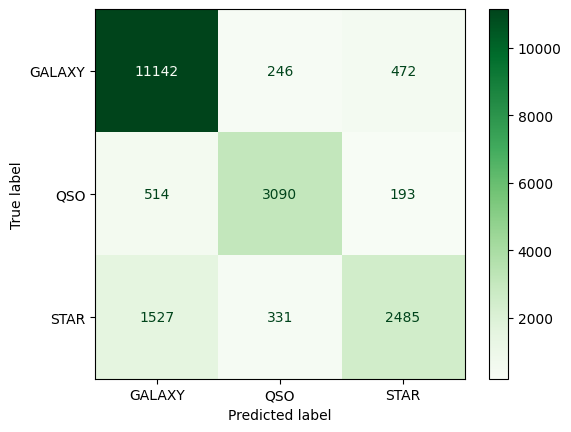

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_test, Y_pred, labels=['GALAXY','QSO','STAR'])
disp = ConfusionMatrixDisplay(cm, display_labels=['GALAXY','QSO','STAR'])
disp.plot(cmap='Greens', values_format='d')
plt.show()

KNN-Classifer on Scaled Feature space

In [36]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(Xsc_train, Y_train)

Y_pred = model.predict(Xsc_test)

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

      GALAXY       0.95      0.96      0.95     11860
         QSO       0.96      0.91      0.93      3797
        STAR       0.92      0.94      0.93      4343

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000



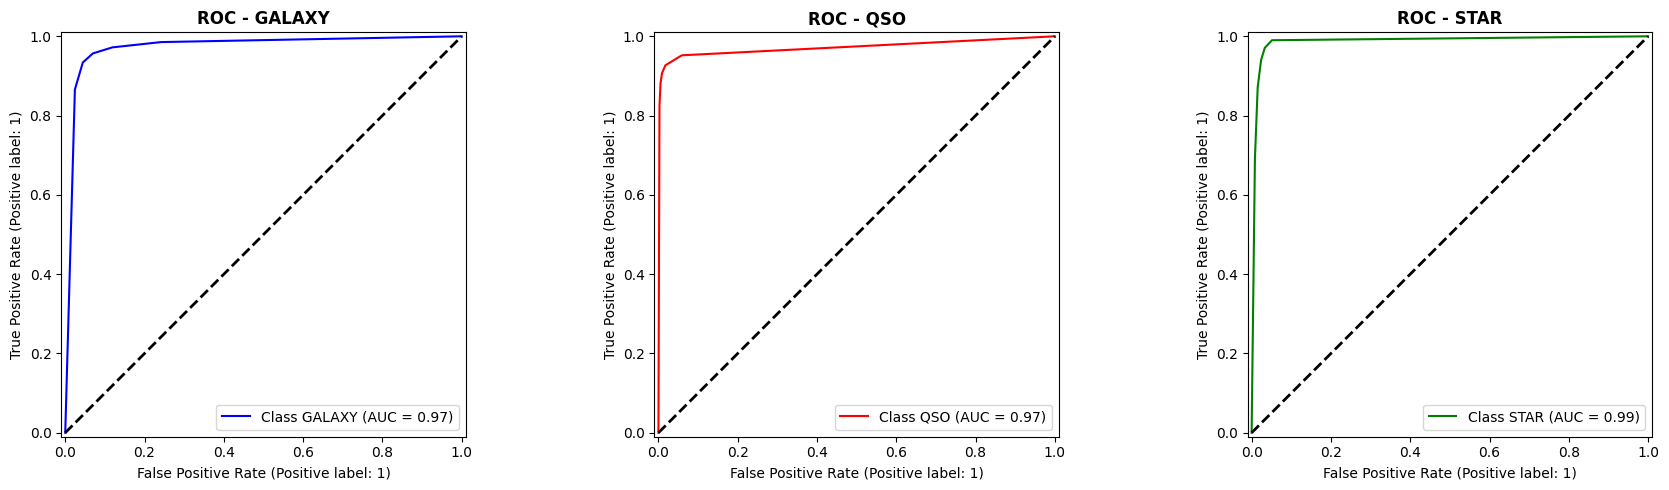

In [ ]:
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import label_binarize


classes = model.classes_  
y_test_bin = label_binarize(Y_test, classes=classes)
y_score = model.predict_proba(Xsc_test)

fig, axes = plt.subplots(1, len(classes), figsize=(18, 5))
colors = ['blue', 'red', 'green']

for i, (ax, class_name, color) in enumerate(zip(axes, classes, colors)):
    RocCurveDisplay.from_predictions(
        y_test_bin[:, i],
        y_score[:, i],
        name=f"Class {class_name}",
        ax=ax,
        color=color
    )
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_title(f"ROC - {class_name}", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


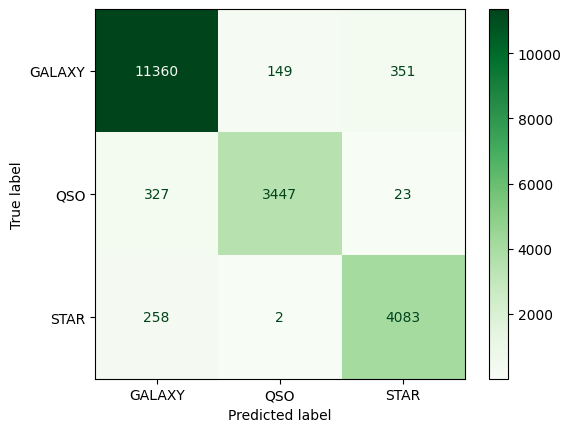

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_test, Y_pred, labels=['GALAXY','QSO','STAR'])
disp = ConfusionMatrixDisplay(cm, display_labels=['GALAXY','QSO','STAR'])
disp.plot(cmap='Greens', values_format='d')
plt.show()

### Inference

* Why Scaling is Important for KNN ? \
KNN uses **distance metrics** (usually Euclidean) to find the nearest neighbors.  
If features are on very different scales (e.g., RA/Dec in hundreds vs. magnitudes around 15–25),  
large-scale features dominate the distance calculation, causing poor classification.

* By applying **StandardScaler** (zero mean, unit variance), all features contribute equally to the distance.  
This led to a major performance boost — **accuracy improved from ~84% (unscaled) to ~94% (scaled)**.


### Hyperparameter tuning of KNN , to find optimum number of neighbours

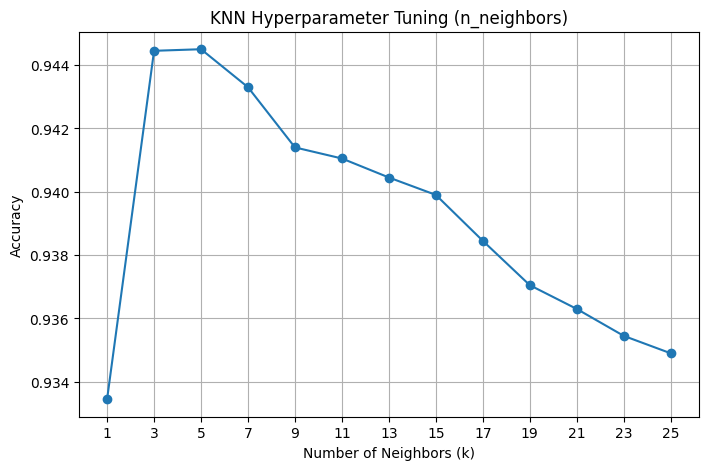

Best k: 5 with accuracy: 0.9445


In [68]:
neighbors = range(1, 26,2)
accuracies = []

for k in neighbors:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(Xsc_train, Y_train)
    Y_pred = model.predict(Xsc_test)
    acc = accuracy_score(Y_test, Y_pred)
    accuracies.append(acc)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(neighbors, accuracies, marker='o')
plt.title("KNN Hyperparameter Tuning (n_neighbors)")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.xticks(neighbors)
plt.show()

best_k = neighbors[accuracies.index(max(accuracies))]
print(f"Best k: {best_k} with accuracy: {max(accuracies):.4f}")

# **Better Models**

1.   Multiclass SVM
2.   Decision Tree
3.   Random Forest

### **Multi-Class SVM with Kernel**

Support Vector Machines (SVM) are powerful classifiers that work well for non-linear decision boundaries.  
By using kernels (e.g., RBF), we can map the feature space into higher dimensions and separate classes more effectively.

### Multi-Class Setup
We use **One-vs-Rest (OvR)** or **One-vs-One (OvO)** internally (handled automatically by `sklearn.svm.SVC`)  
to support our three-class classification problem (`STAR`, `GALAXY`, `QSO`).

### Hyperparameter Tuning
We did **Manual Grid Search** to find the best combination of:
- **C** (regularization strength)
- **gamma** (kernel coefficient for RBF)
- **kernel** (linear vs. RBF)

This ensures we get the optimal bias-variance tradeoff for our model.

In [ ]:
from sklearn.svm import SVC

C_values = [0.1, 1,10]
gamma_values = ['scale', 'auto']
kernels = ['rbf', 'linear']

best_score = 0
best_params = {}

In [ ]:
for C in C_values:
    for gamma in gamma_values:
        for kernel in kernels:
            model = SVC(C=C, gamma=gamma, kernel=kernel, class_weight='balanced')
            model.fit(Xsc_train, Y_train)

            Y_pred = model.predict(Xsc_test)
            acc = accuracy_score(Y_test, Y_pred)

            print(f"C={C}, gamma={gamma}, kernel={kernel}, accuracy={acc:.4f}")

            if acc > best_score:
                best_score = acc
                best_params = {'C': C, 'gamma': gamma, 'kernel': kernel}
                best_model = model

print(f"\nBest Parameters: {best_params}, Best Accuracy: {best_score:.4f}")

C=0.1, gamma=scale, kernel=rbf, accuracy=0.9399
C=0.1, gamma=scale, kernel=linear, accuracy=0.9389
C=0.1, gamma=auto, kernel=rbf, accuracy=0.9399
C=0.1, gamma=auto, kernel=linear, accuracy=0.9389
C=1, gamma=scale, kernel=rbf, accuracy=0.9545
C=1, gamma=scale, kernel=linear, accuracy=0.9528
C=1, gamma=auto, kernel=rbf, accuracy=0.9545
C=1, gamma=auto, kernel=linear, accuracy=0.9528
C=10, gamma=scale, kernel=rbf, accuracy=0.9650
C=10, gamma=scale, kernel=linear, accuracy=0.9560
C=10, gamma=auto, kernel=rbf, accuracy=0.9650
C=10, gamma=auto, kernel=linear, accuracy=0.9560

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}, Best Accuracy: 0.9650


After performing hyperparameter tuning (Manual Grid Search),  
the **best SVM configuration** was found to be:

- **C:** `10`  
- **Gamma:** `scale`  
- **Kernel:** `rbf`

This combination provided the highest accuracy and a good balance  
between precision and recall across all three classes (STAR, GALAXY, QSO).

In [ ]:
best_model = SVC(C=10, gamma="scale", kernel="rbf", class_weight='balanced', probability=True)
best_model.fit(Xsc_train, Y_train)

SVC(C=10, class_weight='balanced', probability=True)

In [ ]:
Y_pred = best_model.predict(Xsc_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

      GALAXY       0.98      0.96      0.97     11860
         QSO       0.94      0.93      0.93      3797
        STAR       0.96      1.00      0.98      4343

    accuracy                           0.97     20000
   macro avg       0.96      0.97      0.96     20000
weighted avg       0.97      0.97      0.97     20000



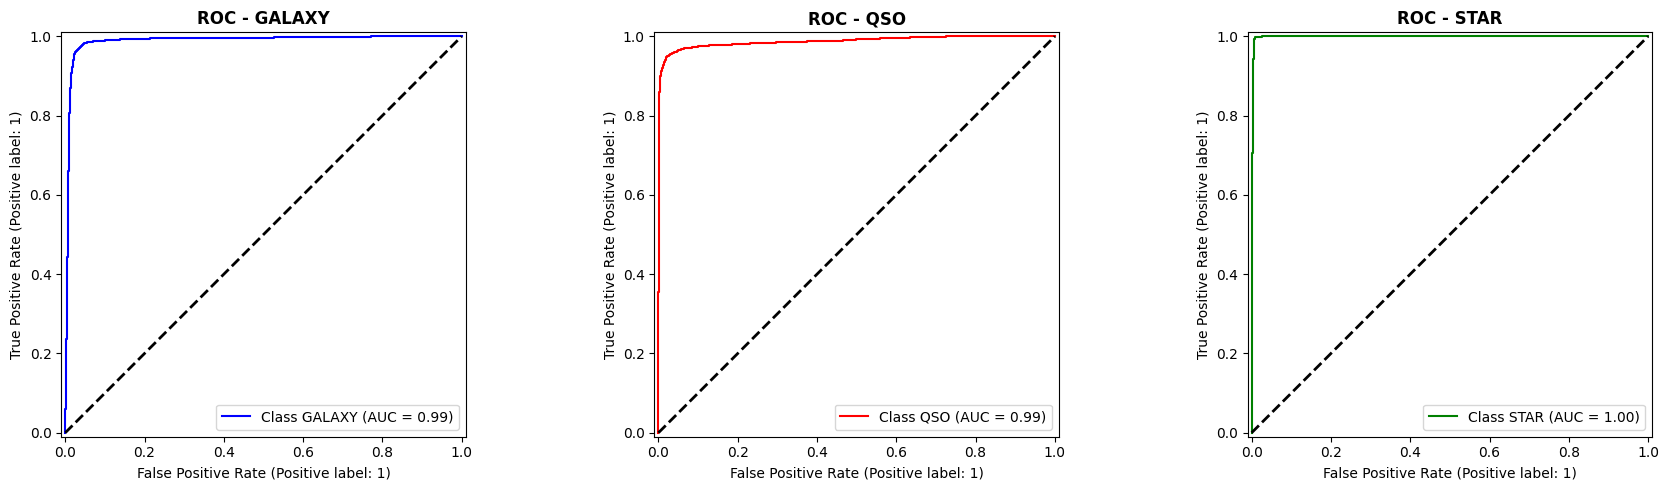

In [ ]:
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import label_binarize

classes = best_model.classes_  
y_test_bin = label_binarize(Y_test, classes=classes)
y_score = best_model.predict_proba(Xsc_test)

fig, axes = plt.subplots(1, len(classes), figsize=(18, 5))
colors = ['blue', 'red', 'green']

for i, (ax, class_name, color) in enumerate(zip(axes, classes, colors)):
    RocCurveDisplay.from_predictions(
        y_test_bin[:, i],
        y_score[:, i],
        name=f"Class {class_name}",
        ax=ax,
        color=color
    )
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_title(f"ROC - {class_name}", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


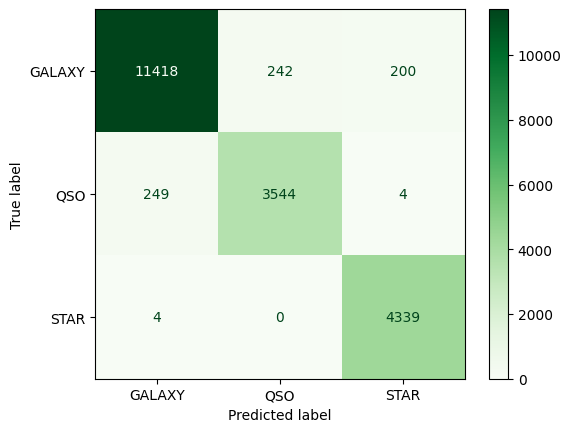

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_test, Y_pred, labels=['GALAXY','QSO','STAR'])   
disp = ConfusionMatrixDisplay(cm, display_labels=['GALAXY','QSO','STAR'])
disp.plot(cmap='Greens', values_format='d')
plt.show()

### Inference

* No independence assumption: SVM handles correlated features (color indices) naturally
* Non-linear decision boundaries: Captures complex class separations in feature space
* Robust to class imbalance: OvR strategy treats each class fairly

### **Decision Tree**

In [23]:
from sklearn.tree import DecisionTreeClassifier


model = DecisionTreeClassifier(criterion='entropy',max_depth=6,random_state=42)

model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

      GALAXY       0.96      0.99      0.98     11860
         QSO       0.96      0.89      0.92      3797
        STAR       1.00      1.00      1.00      4343

    accuracy                           0.97     20000
   macro avg       0.97      0.96      0.96     20000
weighted avg       0.97      0.97      0.97     20000



In [19]:
from sklearn.tree import plot_tree

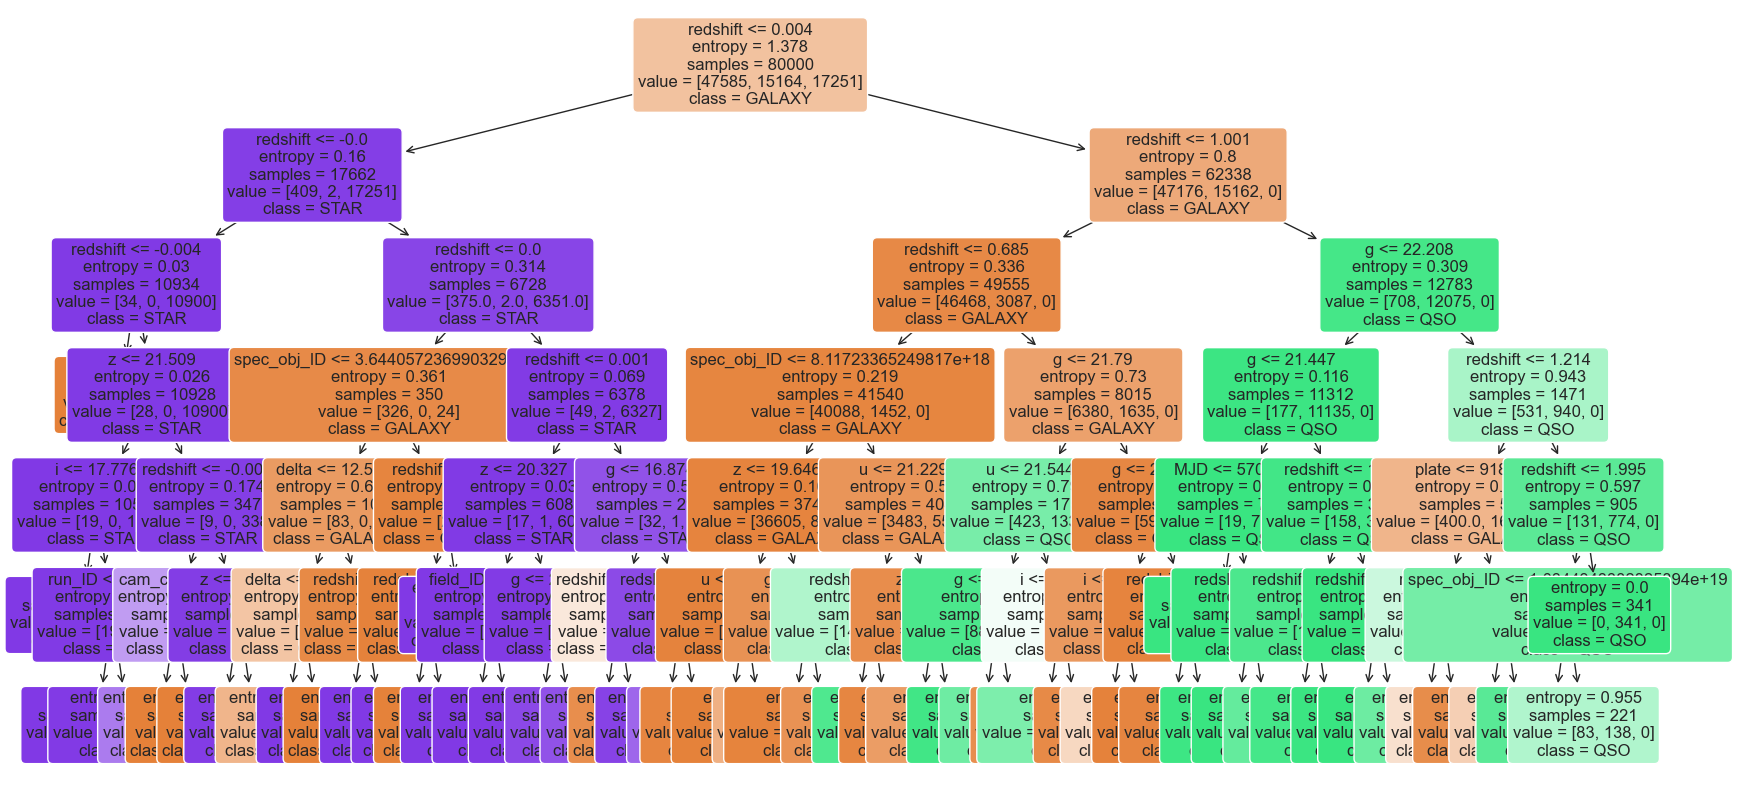

In [24]:
# ploting the dendogram view of the decision tree
plt.figure(figsize=(20, 10))
plot_tree(model, 
          feature_names=X_train.columns,  
          class_names=model.classes_, 
          filled=True,                   
          rounded=True, 
          fontsize=12)
plt.show()

### Hyperparameter Tuning

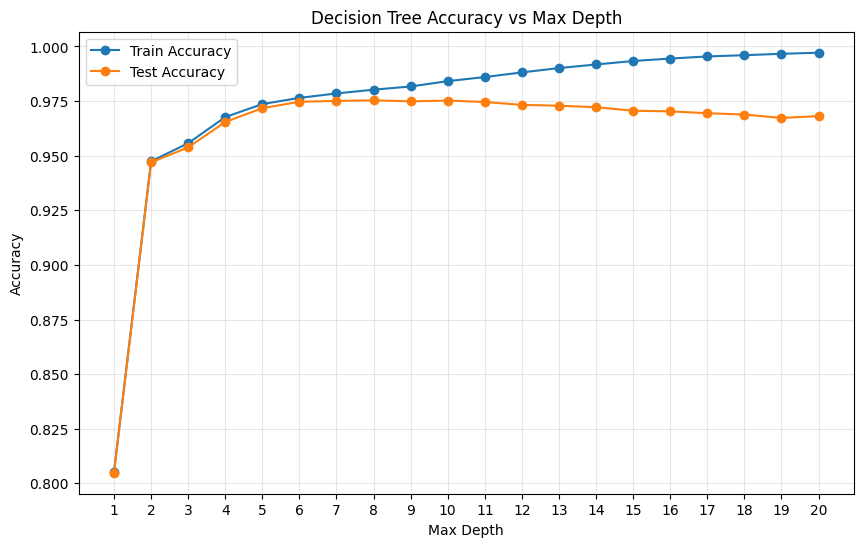

In [ ]:
# finding the optimal depth 
depths = list(range(1, 21))  
train_acc = []
test_acc = []

for d in depths:
    model = DecisionTreeClassifier(criterion='gini', max_depth=d, random_state=42)
    model.fit(X_train, Y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_acc.append(accuracy_score(Y_train, y_train_pred))
    test_acc.append(accuracy_score(Y_test, y_test_pred))

plt.figure(figsize=(10, 6))
plt.plot(depths, train_acc, label='Train Accuracy', marker='o')
plt.plot(depths, test_acc, label='Test Accuracy', marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Accuracy vs Max Depth')
plt.xticks(depths)
plt.grid(alpha=0.3)
plt.legend()
plt.show()


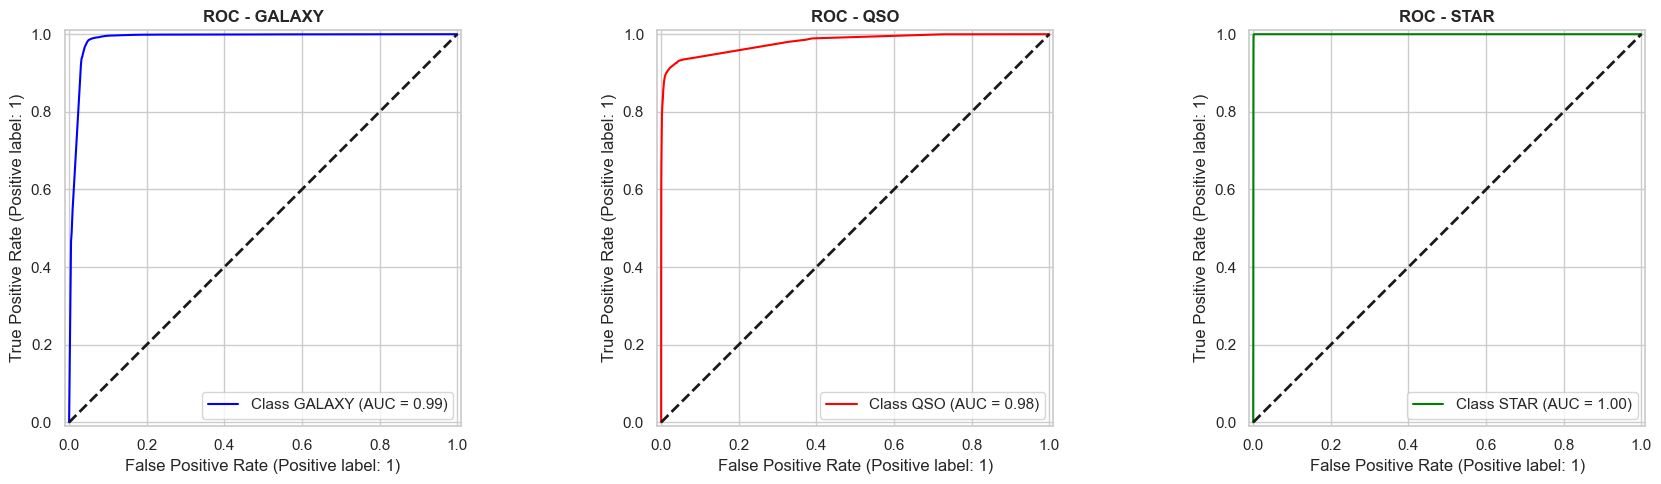

In [25]:
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import label_binarize

classes = model.classes_
y_test_bin = label_binarize(Y_test, classes=classes)
y_score = model.predict_proba(X_test)

fig, axes = plt.subplots(1, len(classes), figsize=(18, 5))
colors = ['blue', 'red', 'green']

for i, (ax, class_name, color) in enumerate(zip(axes, classes, colors)):
    RocCurveDisplay.from_predictions(
        y_test_bin[:, i],
        y_score[:, i],
        name=f"Class {class_name}",
        ax=ax,
        color=color
    )
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_title(f"ROC - {class_name}", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

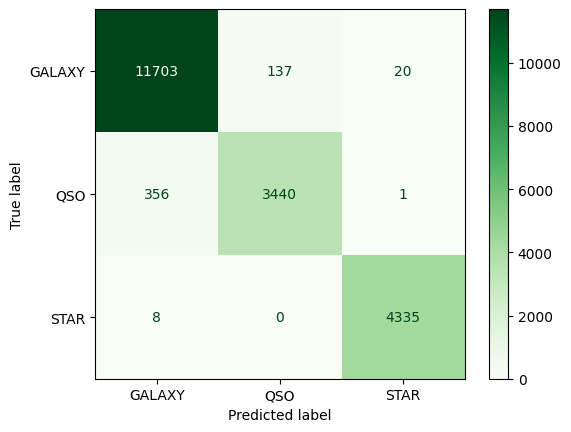

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_test, Y_pred, labels=['GALAXY','QSO','STAR'])
disp = ConfusionMatrixDisplay(cm, display_labels=['GALAXY','QSO','STAR'])
disp.plot(cmap='Greens', values_format='d')
plt.show()

We trained a **Decision Tree Classifier** with no depth restrictions (`max_depth=None`), allowing it to grow until all leaves are pure or until all leaves contain fewer than the minimum samples required to split.

#### Inference
* **High Performance:** The tree achieves an impressive **96% accuracy**, with near-perfect classification of STAR and GALAXY objects.

* Decision trees split features to maximize **information gain** (or minimize Gini impurity).  
For SDSS data, splits often occur on: \

`Redshift`: Very effective at separating QSO from STAR/GALAXY. \
`Photometric Magnitudes (u, g, r, i, z)`: Help classify stars vs galaxies based on brightness in different bands. \
`Color Indices (e.g., u-g, g-r)`: Derived features that represent temperature and distance, often critical for stellar classification.

### **Random Forest**

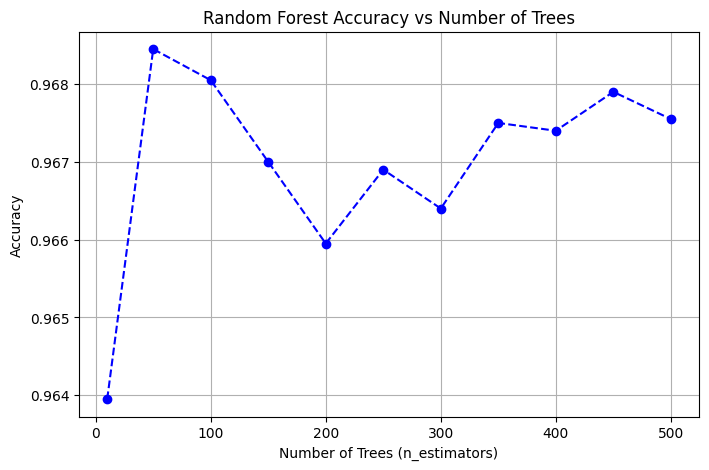

In [ ]:
from sklearn.ensemble import RandomForestClassifier

n_estimators_list = [10, 50, 100,150, 200,250, 300,350,400,450, 500]

accuracies = []

for n in n_estimators_list:
    model = RandomForestClassifier(n_estimators=n,criterion='gini',max_depth=6,random_state=42,n_jobs=-1)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    acc = accuracy_score(Y_test, Y_pred)
    accuracies.append(acc)

# Plot results
plt.figure(figsize=(8,5))
plt.plot(n_estimators_list, accuracies, marker='o', linestyle='--', color='b')
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Accuracy")
plt.title("Random Forest Accuracy vs Number of Trees")
plt.grid(True)
plt.show()

In [ ]:
best_n = n_estimators_list[accuracies.index(max(accuracies))]
print(f"Best number of trees: {best_n}, Accuracy: {max(accuracies):.4f}")

best_model = RandomForestClassifier(
    n_estimators=best_n,
    criterion='gini',
    max_depth=6,
    random_state=42,
    n_jobs=-1
)
best_model.fit(X_train, Y_train)

Y_pred_best = best_model.predict(X_test)
print(classification_report(Y_test, Y_pred_best))

Best number of trees: 50, Accuracy: 0.9685
              precision    recall  f1-score   support

      GALAXY       0.97      0.98      0.97     11860
         QSO       0.95      0.90      0.93      3797
        STAR       0.98      1.00      0.99      4343

    accuracy                           0.97     20000
   macro avg       0.97      0.96      0.96     20000
weighted avg       0.97      0.97      0.97     20000



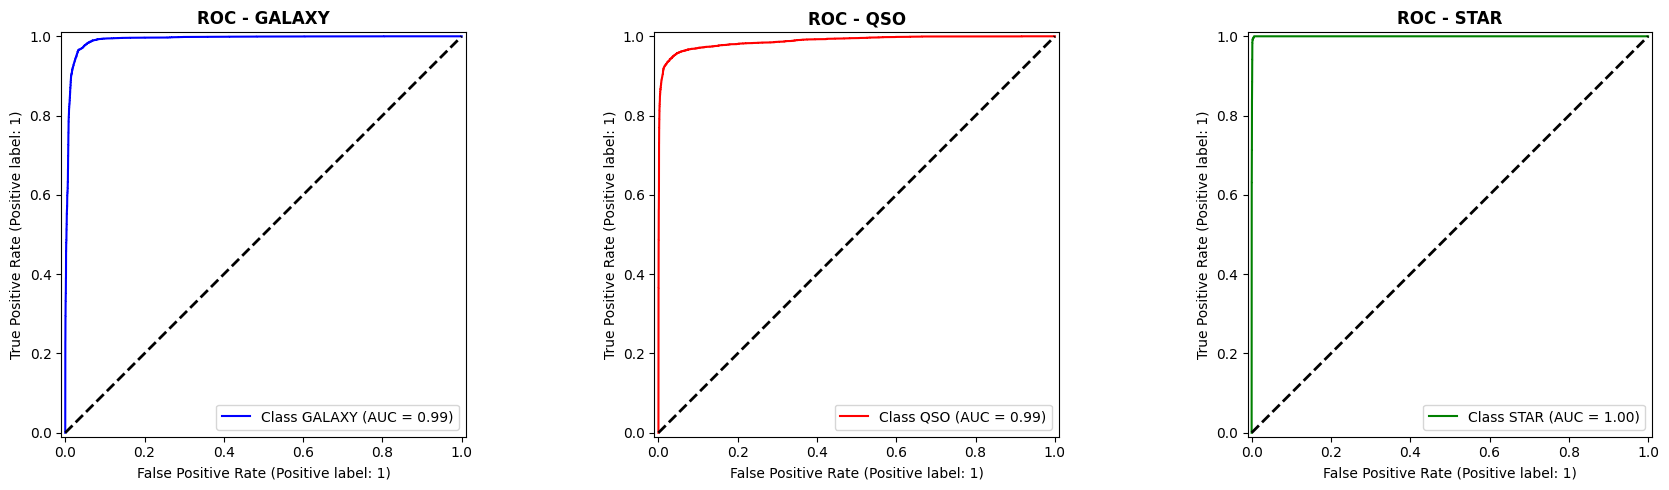

In [ ]:
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import label_binarize

classes = model.classes_ 
y_test_bin = label_binarize(Y_test, classes=classes)
y_score = model.predict_proba(X_test)

fig, axes = plt.subplots(1, len(classes), figsize=(18, 5))
colors = ['blue', 'red', 'green']

for i, (ax, class_name, color) in enumerate(zip(axes, classes, colors)):
    RocCurveDisplay.from_predictions(
        y_test_bin[:, i],
        y_score[:, i],
        name=f"Class {class_name}",
        ax=ax,
        color=color
    )
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_title(f"ROC - {class_name}", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


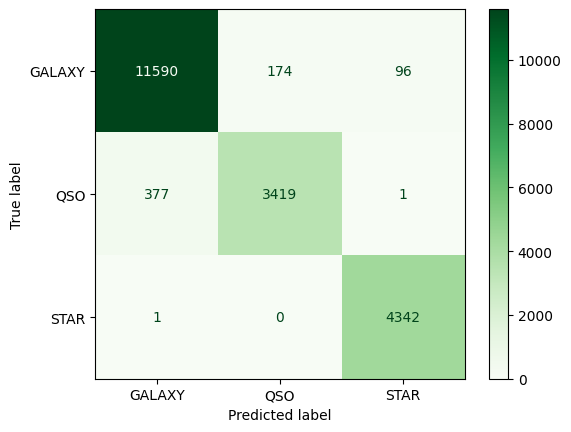

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_test, Y_pred, labels=['GALAXY','QSO','STAR'])
disp = ConfusionMatrixDisplay(cm, display_labels=['GALAXY','QSO','STAR'])
disp.plot(cmap='Greens', values_format='d')
plt.show()

### Inference
We trained a Random Forest Classifier on the SDSS dataset with **150 trees** (n_estimators=150), using the Gini criterion and fully grown trees (max_depth=None).
* Accuracy: 0.9786 (~97.86%)
* High accuracy for STAR and GALAXY classes.
* Slightly lower recall for QSO indicates some misclassifications.
* Random Forest combines multiple trees to reduce overfitting and improve generalization.




## Future Plans 

### Verification of Claims Presented in the Paper

To ensure the reliability and reproducibility of the referenced study, the following validation steps will be conducted:

* **Density Estimation for Redshift**
  Evaluate how accurately the model captures the distribution of redshift values across different object classes (stars, galaxies, quasars). This involves:

  * Comparing predicted vs. true redshift density plots
  * Assessing model calibration and bias in redshift estimation

* **Feature Contribution to Prediction**
  Analyze the influence of individual features on the model’s classification and regression outputs using:

  * SHAP (SHapley Additive exPlanations) or feature importance analysis
  * Visualization of key spectral or photometric attributes driving predictions

### Suggestions

* Handle Class imbalance
* Fully indenpendent feature selection


# Work in progress


### **XGBoost**

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:33:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:33:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:33:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:33:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:33:20] WARNING: /w

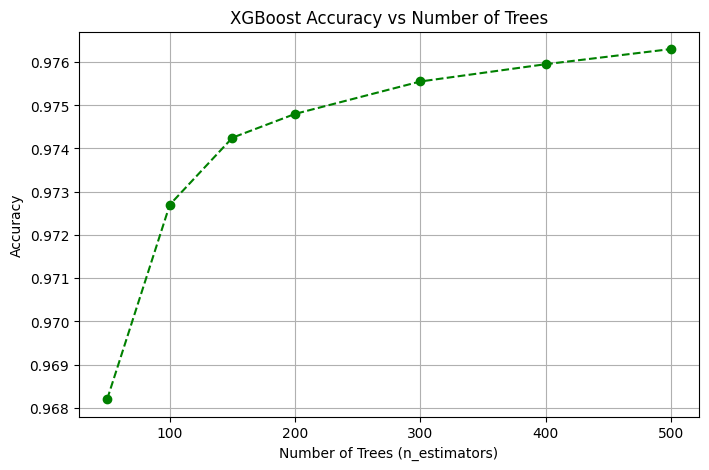

In [ ]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
Y_encoded = le.fit_transform(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y_encoded, test_size=0.2, random_state=42)

n_estimators_list = [50, 100,150, 200, 300,400, 500]

accuracies = []

for n in n_estimators_list:
    model = XGBClassifier(
        n_estimators=n,
        learning_rate=0.1,
        max_depth=3,
        random_state=42,
        use_label_encoder=False,
        eval_metric="logloss"   # avoid warning
    )
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    acc = accuracy_score(Y_test, Y_pred)
    accuracies.append(acc)

# Plot results
plt.figure(figsize=(8,5))
plt.plot(n_estimators_list, accuracies, marker='o', linestyle='--', color='g')
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Accuracy")
plt.title("XGBoost Accuracy vs Number of Trees")
plt.grid(True)
plt.show()


In [ ]:
best_n = n_estimators_list[accuracies.index(max(accuracies))]
print(f"Best n_estimators: {best_n}, Accuracy: {max(accuracies):.4f}")

best_model = XGBClassifier(
    n_estimators=best_n,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)
best_model.fit(X_train, Y_train)

Y_pred_best = best_model.predict(X_test)
print(classification_report(Y_test, Y_pred_best))

Best n_estimators: 500, Accuracy: 0.9763


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:35:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.97      0.99      0.98     11860
           1       0.97      0.92      0.95      3797
           2       0.99      1.00      0.99      4343

    accuracy                           0.98     20000
   macro avg       0.98      0.97      0.97     20000
weighted avg       0.98      0.98      0.98     20000



We trained an XGBoost Classifier on the SDSS dataset with **n_estimators=best_n** (optimal number of boosting rounds), using a learning rate of 0.1 and max_depth of 3.

**Performance:**
- Accuracy: 0.9763 (~97.63%)

**Interpretation:**
- High accuracy overall (~97.63%) with excellent classification of STAR and GALAXY classes.
- Slightly lower recall for class 1 (QSO) indicates some misclassifications.
- XGBoost uses gradient boosting to combine weak learners into a strong ensemble, improving accuracy and generalization compared to a single tree.


### **AdaBoost**

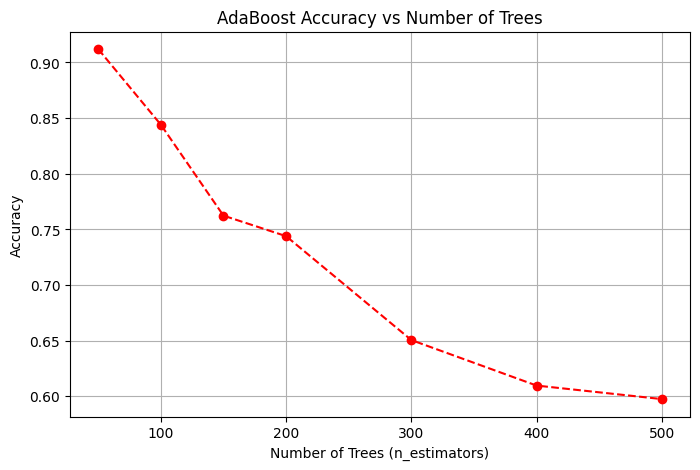

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

n_estimators_list = [50, 100,150, 200, 300,400, 500]


accuracies = []

for n in n_estimators_list:
    model = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1),
        n_estimators=n,
        learning_rate=1.0,
        random_state=42
    )
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    acc = accuracy_score(Y_test, Y_pred)
    accuracies.append(acc)

plt.figure(figsize=(8,5))
plt.plot(n_estimators_list, accuracies, marker='o', linestyle='--', color='r')
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Accuracy")
plt.title("AdaBoost Accuracy vs Number of Trees")
plt.grid(True)
plt.show()


In [ ]:
best_n = n_estimators_list[accuracies.index(max(accuracies))]
print(f"Best n_estimators: {best_n}, Accuracy: {max(accuracies):.4f}")

best_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=best_n,
    learning_rate=1.0,
    random_state=42
)
best_model.fit(X_train, Y_train)

Y_pred_best = best_model.predict(X_test)
print(classification_report(Y_test, Y_pred_best))

Best n_estimators: 50, Accuracy: 0.9120
              precision    recall  f1-score   support

      GALAXY       0.95      0.90      0.92     11860
         QSO       0.75      0.85      0.80      3797
        STAR       0.98      1.00      0.99      4343

    accuracy                           0.91     20000
   macro avg       0.89      0.92      0.90     20000
weighted avg       0.92      0.91      0.91     20000



We trained an AdaBoost Classifier on the SDSS dataset using **50 boosting rounds** (n_estimators=50) with Decision Stumps (trees of max_depth=1) as base learners.

**Performance:**
- Accuracy: 0.9120 (~91.2%)

**Interpretation:**
- AdaBoost performs well for STAR and GALAXY, but lower for QSO (precision 0.75) due to weaker base learners.  
- Overall accuracy (~91.2%) is lower than Random Forest and XGBoost.  
- AdaBoost combines multiple weak learners sequentially, focusing on misclassified samples to improve performance, but is sensitive to noisy data.
